# Package Imports #

In [96]:
# Import the necessary packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as mpgs
import glob
%matplotlib inline

# Helper Functions #

In [97]:
# Helper function to merge two lists of images, alternating between both lists
# This is required to display images for comparison

def merge_lists(imgarray1, imgarray2, count=None):
    
    if count is None:
        count = len(imgarray1)
    output = []
    for i in range(count):
        output.append(imgarray1[i])
        output.append(imgarray2[i])
    
    return output

In [98]:
# Helper function to display images
# The input array should contain an even number of images

def display_images(imgarray, titles=None, cmap=None):
    ncols = 2
    nrows = int(len(imgarray)/2)
    figsize = (ncols*9, nrows*7)
        
    fig = plt.figure(figsize=figsize)
    gs = mpgs.GridSpec(nrows, ncols)
    gs.update(bottom=0.375)
    for i in range(len(imgarray)):
        sub = plt.subplot(gs[i])
        if titles is not None:
            sub.set_title(titles[i], size=17)
        sub.imshow(imgarray[i], cmap=cmap)


In [99]:
# Helper function to calibrate the camera

def calibrate_camera(chess_images):
       
    objpoints = []
    imgpoints = []
    
    # Initialize grid points to feed to objpoints
    objpoints_base = np.zeros((rows*cols, 3), np.float32)
    objpoints_base[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

    for img in chess_images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows))
        
        if(ret):
            # Append points and actual co-ordinates
            objpoints.append(objpoints_base)
            imgpoints.append(corners)
    
    print("\nCalibrating the camera using {} of {} chessboard images".format(len(imgpoints), len(chess_images)))
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
       
    # Return the camera matrix and distortion coefficients
    return mtx, dist

In [100]:
# Helper function to undistort images

def undistort_images(dist_images, mtx, dist, multi=False):
    
    # For a single image
    if not multi:
        return cv2.undistort(dist_images, mtx, dist)
        
    # Use cv2 to undistort each image
    undistorted_images = np.array([cv2.undistort(img, mtx, dist) for img in dist_images])
    
    return undistorted_images

In [101]:
# Helper function to warp images with a perspective transform

def warp_images(src_images, M, multi=False):
    
    # For a single image
    if not multi:
        return cv2.warpPerspective(src_images, M, src_images.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    # Calculate the image shape
    shape = src_images[0].shape[1::-1]
    
    # Use cv2 to apply the perspective transform on each image
    warped_images = np.array([cv2.warpPerspective(img, M, shape,
                                                  flags=cv2.INTER_LINEAR) for img in src_images])
    
    return warped_images 

In [102]:
# Helper function to apply a region of interest mask

def region_mask(img):
    
    # Create an all-zero mask
    mask = np.zeros_like(img)
    out_mask_color = 1
    mask = mask.astype(np.float32)
    
    # Define polygon co-ordinates
    bottom_left = [235, 668]
    top_left = [595, 435]
    top_right = [705, 435]
    bottom_right = [1060, 668]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)


    # Fill poly and apply to the mask
    cv2.fillPoly(mask, vertices, out_mask_color)
    
    # Retain only the ROI on the original image
    mask = mask.astype(np.uint8)
    img = img.astype(np.uint8)
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    
    return masked_image

In [103]:
# Helper function to apply color thresholding

def color_filters(img, s_thresholds=(100,255)):
    
    # Convert to HLS space and isolate the S channel
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    
    # Prepare a binary output based on thresholds
    binary_img = np.zeros_like(s_channel)
    binary_img[(s_channel > s_thresholds[0]) & (s_channel <= s_thresholds[1])] = 1
    
    return binary_img

In [104]:
# Helper function that takes a grayscale image and applies gradient thresholds

def gradient_filters(img, sobel_kernel=5, mag_thresholds=(100,200), 
                     x_thresholds=(25,255), 
                                dir_thresholds=(np.pi*45/180, np.pi*80/180)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradients along x and y axes
    x_grad = np.abs(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    y_grad = np.abs(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    abs_x_grad = np.abs(x_grad)
    abs_y_grad = np.abs(y_grad)
    
    scaled_img_x = np.uint(255*abs_x_grad/np.max(abs_x_grad))
    scaled_img_y = np.uint(255*abs_y_grad/np.max(abs_y_grad))
    
    # Calculate the magnitude of the gradients
    mag_grad = np.sqrt(x_grad**2 + y_grad**2)
    mag_grad = np.uint8(255 * mag_grad / np.max(mag_grad))
    
    # Caculdate gradient angle
    dir_angle = np.arctan2(y_grad, x_grad)
    # Combine thresholds
    binary_output = np.zeros_like(scaled_img_x)
    binary_output[\
                #(mag_grad > mag_thresholds[0]) & (mag_grad <= mag_thresholds[1]) &\
                 (scaled_img_x > x_thresholds[0]) & (scaled_img_x <= x_thresholds[1]) &\
                  (dir_angle > dir_thresholds[0]) & (dir_angle <= dir_thresholds[1])\
                 ] = 1
    
    return binary_output

In [151]:
# class to keep track of Lane line information

from collections import deque

class Lane():
    
    def __init__(self, retain, max_undetected):
        
        # Initial declarations
        self.retain = retain
        self.max_undetected = max_undetected
        
        self.undetected_count = 0
        self.ym_per_pix = 30/720 
        self.xm_per_pix = 3.7/700 
        
        # Deque object to maintain the last n polyfits
        self.last_n_polyfit = deque(maxlen=retain)
        
        # Curvature radius in m.
        self.current_curvature = None
        
        # Horizontal distance for sanity check
        self.last_n_hdist = deque(maxlen=retain)
        self.current_hdist = None
    
    def add_polyfit(self, fit):
        self.last_n_polyfit.append(fit)
        
    def get_mean_polyfit(self):
        
        return np.mean(self.last_n_polyfit, 0)
    
    def clear_undetected_count(self):
        self.undetected_count = 0
    
    def update_undetected_count(self):
        
        self.undetected_count += 1
        return self.undetected_count
    
    def is_reset_required(self):
        print("Current hdist is {:f} and mean is {:f}".format(self.current_hdist, np.mean(self.last_n_hdist)))
        
        return (self.undetected_count >= self.max_undetected)
    
    def calculate_curvature(self, xpts, ypts):
        
        # Fit new polynomials to x,y in world space
        fit_meters = np.polyfit(ypts*self.ym_per_pix, xpts*self.xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_meters[0]*720*self.ym_per_pix + fit_meters[1])**2)**1.5) /\
        np.absolute(2*fit_meters[0])
        
        self.current_curvature = curverad
    
    def get_curvature(self):
        
        return self.current_curvature
    
    def update_hdistance(self, mean_hdistance):
        
        self.current_hdist = mean_hdistance
        self.last_n_hdist.append(mean_hdistance)
        

# Initial Processing #
Code which uses the helper functions to calibrate the camera. Also demos undistortion.

In [106]:
# Read in all the test images

filenames = glob.glob( "test_images\*.jpg")
test_images = np.array([mpimg.imread(name) for name in filenames])

In [17]:
# Display the first four test images
#display_images(test_images, titles=[x.split("\\")[-1] for x in filenames])

### Camera Calibration ###

In [107]:
# Read the chessboard images
chess_filenames = glob.glob("camera_cal\calibration*.jpg")
chess_images =  np.array([mpimg.imread(name) for name in chess_filenames])
rows, cols = 6, 9

# Call the helper function to calibrate the camera
mtx, dist = calibrate_camera(chess_images)


Calibrating the camera using 17 of 20 chessboard images


In [19]:
# Call the helper function to undistort the test images
#undist_images = undistort_images(chess_images, mtx, dist, multi=True)

# Display 5 chess board images and their undistorted versions
#display_images(merge_lists(chess_images, undist_images, 5 ),titles=["Original", "Undistorted"]*5)

### Perspective Transform ###

In [108]:
# Pick an image for defining the perspective transform
source_img = test_images[0]

# Define the source and destination points for the perspective transform
srcTL = [584, 458]
srcTR = [701, 458]
srcBR = [1030, 668]
srcBL = [283, 668]

src = np.float32([srcTL, srcTR, srcBR, srcBL])
dst = np.float32([[375, 0], [900, 0], [900, 720], [375, 720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped_img = warp_images(source_img, M)

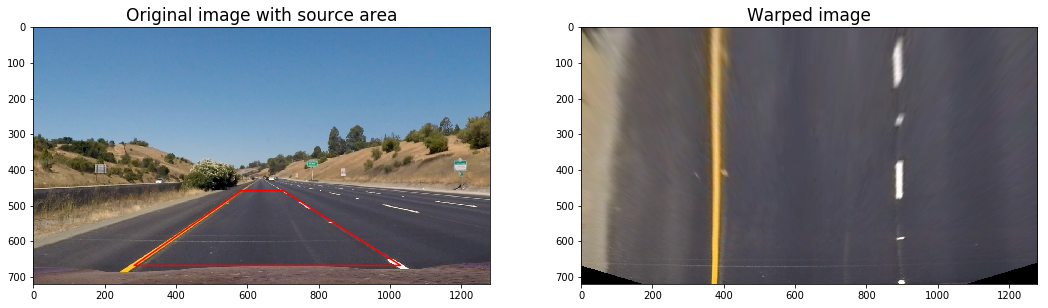

In [21]:
# Compare the original and warped image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,32))
ax1.imshow(source_img)
ax1.plot([srcTL[0], srcTR[0], srcBR[0], srcBL[0], srcTL[0]],
         [srcTL[1], srcTR[1], srcBR[1], srcBL[1], srcTL[1]], color='red')
ax1.set_title("Original image with source area", size=17)
ax2.imshow(warped_img)
ax2.set_title("Warped image", size=17)

In [22]:
# Warp all test images and display them using the helper functions
#display_images(warp_images(test_images, M, multi=True))

### Region of Interest ###

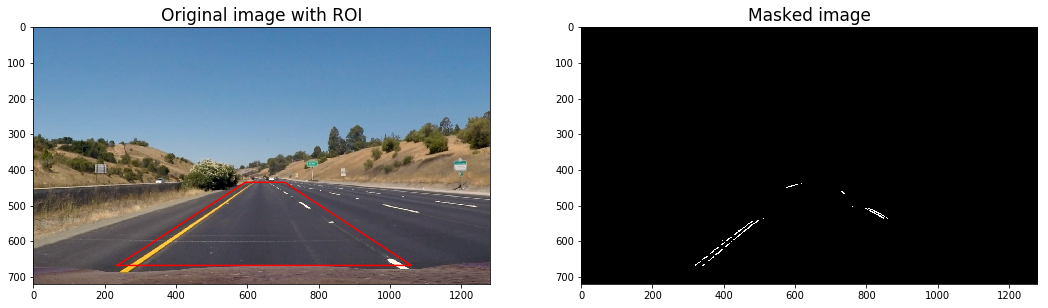

In [109]:
# For clarity, display the ROI on the original image

bottom_left = [235, 668]
top_left = [595, 435]
top_right = [705, 435]
bottom_right = [1060, 668]
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,32))
ax1.imshow(test_images[0])
ax1.plot([bottom_left[0], top_left[0],  top_right[0], bottom_right[0], bottom_left[0]],
        [bottom_left[1], top_left[1],  top_right[1], bottom_right[1], bottom_left[1]], color='red')
ax1.set_title("Original image with ROI", size=17)
ax2.imshow(region_mask(gradient_filters(test_images[5])), cmap='gray')
ax2.set_title("Masked image", size=17)




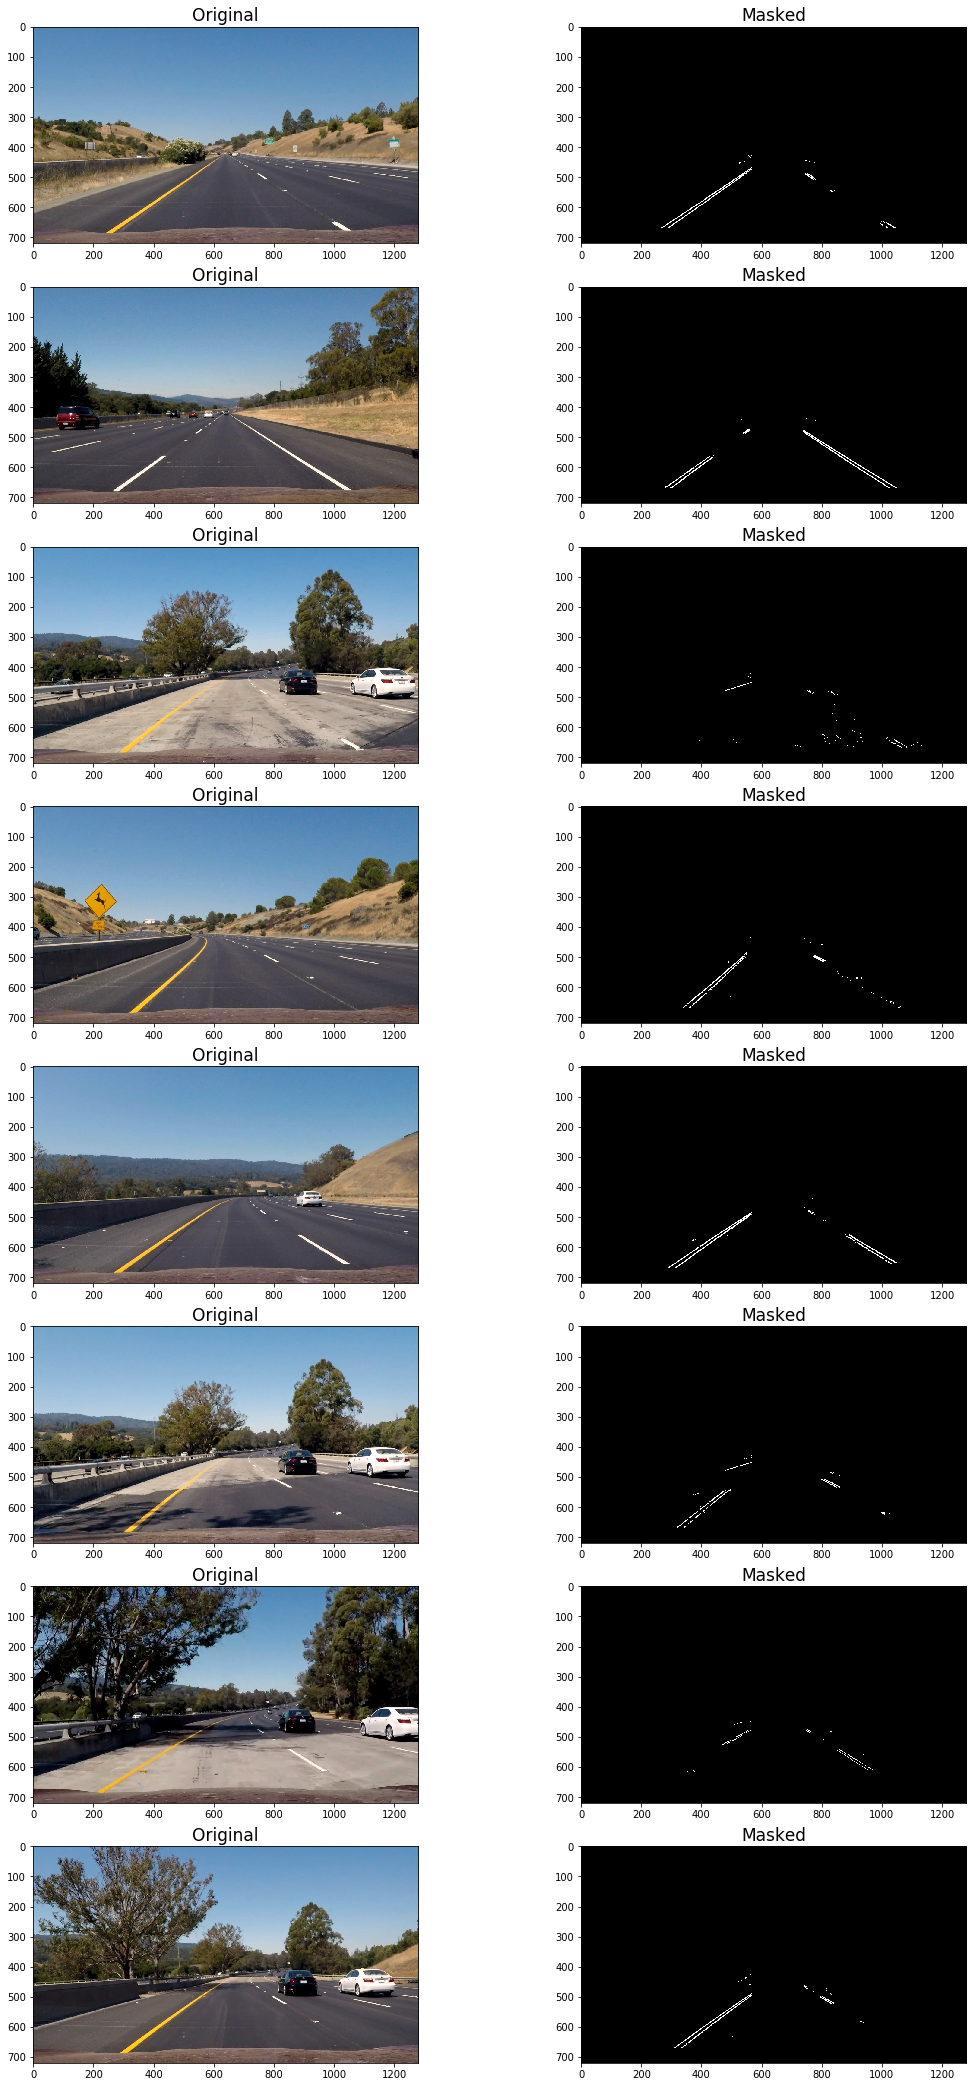

In [60]:
# Display the ROI mask on all test images using the helper function

roi_images = [region_mask(gradient_filters(img)) for img in test_images]
display_images(merge_lists(test_images, roi_images),
               titles = ["Original", "Masked"]*len(test_images), cmap='gray')

### Color Thresholding ###

In [ ]:
# Apply color thresholding on all test images

#s_images = np.array([color_filters(img, s_thresholds=(80,255)) for img in test_images])

#display_images(merge_lists(test_images, s_images), cmap='gray')

### Gradient Thresholding ###

In [ ]:
#grad_images = np.array([gradient_filters(img, sobel_kernel=5,
                                         mag_thresholds=(1,255),
                                        x_thresholds=(25,255),
                                        dir_thresholds=(np.pi*45/180, np.pi*80/180)
                                        ) for img in test_images])

#display_images(merge_lists(test_images, grad_images), titles=["Original", "Thresholded"]*len(test_images), cmap='gray')

# Pipeline #

In [125]:
# Method to find lane lines from scratch

def reset_lane_lines(binary_img, visualize=False):
    
    global left_lane, right_lane
    
    # Find the x base points
    histogram = np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)
    mid = int(len(histogram)/2)
    left_base = np.argmax(histogram[:mid])
    right_base = np.argmax(histogram[mid:])+mid
    
    # Process for visualization
    if visualize:
        disp_img_arr = []
        disp_img_titles= []
        
        # 3 channels, black background, detected pixels in white
        disp_img = np.dstack((binary_img, binary_img, binary_img))*255
        disp_img_arr.append(disp_img)
        disp_img_titles.append("Warped image")
        img = np.copy(disp_img)
        
    # Define the sliding window size
    win_h = 70
     
    # minimum pixels required to re-center
    min_px = 40 
    margin = 100
    
    # window boundaries in y
    y_low = binary_img.shape[0]
    y_top = y_low - win_h
    
    # non-zero pixels
    nonz = binary_img.nonzero()
    nonz_y = np.array(nonz[0])
    nonz_x = np.array(nonz[1])

    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    for window in range(binary_img.shape[0]//win_h):

        # Determine the current window borders
        left_x_l = int(left_base - margin)
        left_x_r = int(left_base + margin)
        
        right_x_l = int(right_base - margin)
        right_x_r = int(right_base + margin)
        
        if visualize: 
            cv2.rectangle(img,(right_x_l, y_low),(right_x_r, y_top),(0,0,255),3)
            cv2.rectangle(img,(left_x_l, y_low),(left_x_r, y_top),(0,255,0),3)
        
        # Determine non-zero pixels within the window
        left_idx = ((nonz_y >= y_top) & (nonz_y <= y_low) & (nonz_x >= left_x_l) & (nonz_x <= left_x_r)).nonzero()[0]
        right_idx = ((nonz_y >= y_top) & (nonz_y <= y_low) & (nonz_x >= right_x_l) & (nonz_x <= right_x_r)).nonzero()[0]
        
        left_x = np.concatenate((left_x, nonz_x[left_idx]))
        left_y = np.concatenate((left_y, nonz_y[left_idx]))
        right_x = np.concatenate((right_x, nonz_x[right_idx]))
        right_y = np.concatenate((right_y, nonz_y[right_idx]))
        
        # Update the window position along y
        y_low = y_low-win_h
        y_top = y_top-win_h
        
        # If enough pixels were found in the current window, update the window's center along x
        if(np.count_nonzero(left_idx) >= min_px):
            left_base = int(np.mean(nonz_x[left_idx]))
        if(np.count_nonzero(right_idx) >= min_px):
            right_base = int(np.mean(nonz_x[right_idx]))
    
    # Return if not enough pixels were detected
    if(len(left_x)==0 or len(right_x)==0):
        return False, None, None
        
    # Fit pixels to a line    
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    # Update the curvature
    left_lane.calculate_curvature(left_x, left_y)
    right_lane.calculate_curvature(right_x, right_y)

    if visualize:
        y_points = np.linspace(0, binary_img.shape[0], binary_img.shape[0], endpoint=False)
        x_points_left = left_fit[0]*y_points**2 + left_fit[1]*y_points + left_fit[2]
        x_points_right = right_fit[0]*y_points**2 + right_fit[1]*y_points + right_fit[2]
        
        cv2.polylines(img, np.array([list(zip(x_points_left, y_points))], dtype=np.int32),
                      isClosed=False, color=((255,0,0)),lineType=4, thickness=3)
        cv2.polylines(img, np.array([list(zip(x_points_right, y_points))], dtype=np.int32),
                      isClosed=False, color=((255,0,0)),lineType=4, thickness=3)
        
        disp_img_arr.append(img)
        disp_img_titles.append("Sliding Windows")
    
    if visualize:
        return disp_img_arr, disp_img_titles, left_fit, right_fit
    else:
        return True, left_fit, right_fit

In [126]:
# Method to find lane lines given previous polyfits

def continue_lane_lines(binary_img, left_fit, right_fit):
    
    nonz = binary_img.nonzero()
    nonz_y = np.array(nonz[0])
    nonz_x = np.array(nonz[1])
    
    margin = 100
    
    left_idx = (nonz_x > (left_fit[0]*(nonz_y**2) + left_fit[1]*nonz_y + left_fit[2] - margin)) &\
    (nonz_x < (left_fit[0]*(nonz_y**2) + left_fit[1]*nonz_y + left_fit[2] + margin))
    right_idx = (nonz_x > (right_fit[0]*(nonz_y**2) + right_fit[1]*nonz_y + right_fit[2] - margin)) &\
    (nonz_x < (right_fit[0]*(nonz_y**2) + right_fit[1]*nonz_y + right_fit[2] + margin))

    # If no pixels were found for the current lane line polyfits, return
    if(np.count_nonzero(left_idx)==0 or np.count_nonzero(right_idx)==0):
        return False, None, None
    
    # Else, calculate and return the new polyfits
    else:   
        left_x = nonz_x[left_idx]
        left_y = nonz_y[left_idx]
        right_x = nonz_x[right_idx]
        right_y = nonz_y[right_idx]
    
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
        
        # Update the curvature
        left_lane.calculate_curvature(left_x, left_y)
        right_lane.calculate_curvature(right_x, right_y)
        
        return True, left_fit, right_fit

In [127]:
# Method that deals with operations related to the lane lines
# Returns the polyfit for both lanes

def get_lane_lines(binary_img):
    
    global left_lane, right_lane, first_run
    # Find lane lines
    if(first_run):
        
        first_run = False
        
        # create new Lane objects to track both lanes
        left_lane = Lane(retain=20, max_undetected=20)
        right_lane = Lane(retain=20, max_undetected=20)
        
        # Reset lane lines since it's the first run
        ret, left_fit, right_fit = reset_lane_lines(binary_img)
        
        left_lane.add_polyfit(left_fit)
        right_lane.add_polyfit(right_fit)
        
        return left_fit, right_fit
        
    else:
        # Get the mean polyfits from the previous frames
        left_fit = left_lane.get_mean_polyfit()
        right_fit = right_lane.get_mean_polyfit()
        
        # Find lane lines on the frame
        ret, left_fit, right_fit = continue_lane_lines(binary_img, left_fit, right_fit)
        if ret:
            # Update the lane lines based on the lines found on the current frame
            left_lane.add_polyfit(left_fit)
            left_lane.clear_undetected_count()
            
            right_lane.add_polyfit(right_fit)
            right_lane.clear_undetected_count()
            
            # Return the mean over the past frames
            
            return left_lane.get_mean_polyfit(), right_lane.get_mean_polyfit()
        
        else:
            # No lane lines were found on the current frame
            count_l = left_lane.update_undetected_count()
            count_r = right_lane.update_undetected_count()
            
            # If lanes were not detected for several frames, reset the polyfits
            if(left_lane.is_reset_required() or right_lane.is_reset_required()):
                ret, left_fit_new, right_fit_new = reset_lane_lines(warped_img)
                
                # If lanes were successfully detected, create new Lane objects and update them
                if ret:
                    left_lane = Lane(retain=20, max_undetected=20)
                    right_lane = Lane(retain=20, max_undetected=20)

                    left_lane.add_polyfit(left_fit)
                    right_lane.add_polyfit(right_fit)

                    return left_fit_new, right_fit_new
            

        # Lanes were not detected using both methods, use mean of the previous frames
        left_fit = left_lane.get_mean_polyfit()
        right_fit = right_lane.get_mean_polyfit()

        return left_fit, right_fit

In [157]:
# Pipeline to perform all necessary operations on invidivdual frames

def pipeline(image, visualize=False):
    
    # Undistort the image
    undist_img = undistort_images(image, mtx, dist)
    
    # Apply color thresholding
    color_thr_img = color_filters(undist_img, s_thresholds=(80,255))
    
    # Apply gradient thresholding
    grad_img = gradient_filters(undist_img, x_thresholds=(25,255), 
                                dir_thresholds=(np.pi*45/180, np.pi*80/180) )
    
    # Combined thresholds
    comb_img = np.zeros_like(grad_img)
    comb_img[(grad_img == 1) | (color_thr_img == 1)] = 1
    
    # Apply ROI
    roi_img = region_mask(comb_img)

    # Perspective transform
    warped_img = warp_images(roi_img, M)
           
    # Get polyfits
    left_fit, right_fit = get_lane_lines(warped_img)
    #ret, left_fit, right_fit = reset_lane_lines(warped_img)
    
    # Draw lane area
    warp_blank = np.zeros_like(warped_img).astype(np.uint8)
    color_blank = np.dstack((warp_blank, warp_blank, warp_blank))
    
    y_points = np.linspace(0, warped_img.shape[0], warped_img.shape[0], endpoint=False)
    x_points_left = left_fit[0]*y_points**2 + left_fit[1]*y_points + left_fit[2]
    x_points_right = right_fit[0]*y_points**2 + right_fit[1]*y_points + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([x_points_left, y_points]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([x_points_right, y_points])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_blank, np.int_([pts]), (0,255, 0))
    
    newwarp = cv2.warpPerspective(color_blank, Minv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    # Calculate and display radius of curvature
    mean_curv = round((left_lane.get_curvature() + right_lane.get_curvature())/2, 2)
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(result, "Radius of Curvatue : " + str(mean_curv) +  " m.",(30,50), font, 3, (0,0,255), thickness=4)

    # Calculate and display the offset
    ymax = result.shape[0]-40
    xl = left_fit[0]*(ymax**2) + left_fit[1]*ymax + left_fit[2]
    xr = right_fit[0]*(ymax**2) + right_fit[1]*ymax + right_fit[2]
    xmean = (xl + xr) /2
    
    offset = round(3.7/700 *(result.shape[1]/2 - xmean), 2)
    message = str(offset)+ " m. off center"
    cv2.putText(result, "Vehicle Offset : " + message ,(30,150), font, 3, (0,0,255), thickness=4)
    
    if visualize:
        return undist_img, color_thr_img, grad_img, comb_img, roi_img, warped_img
    else:
        return result


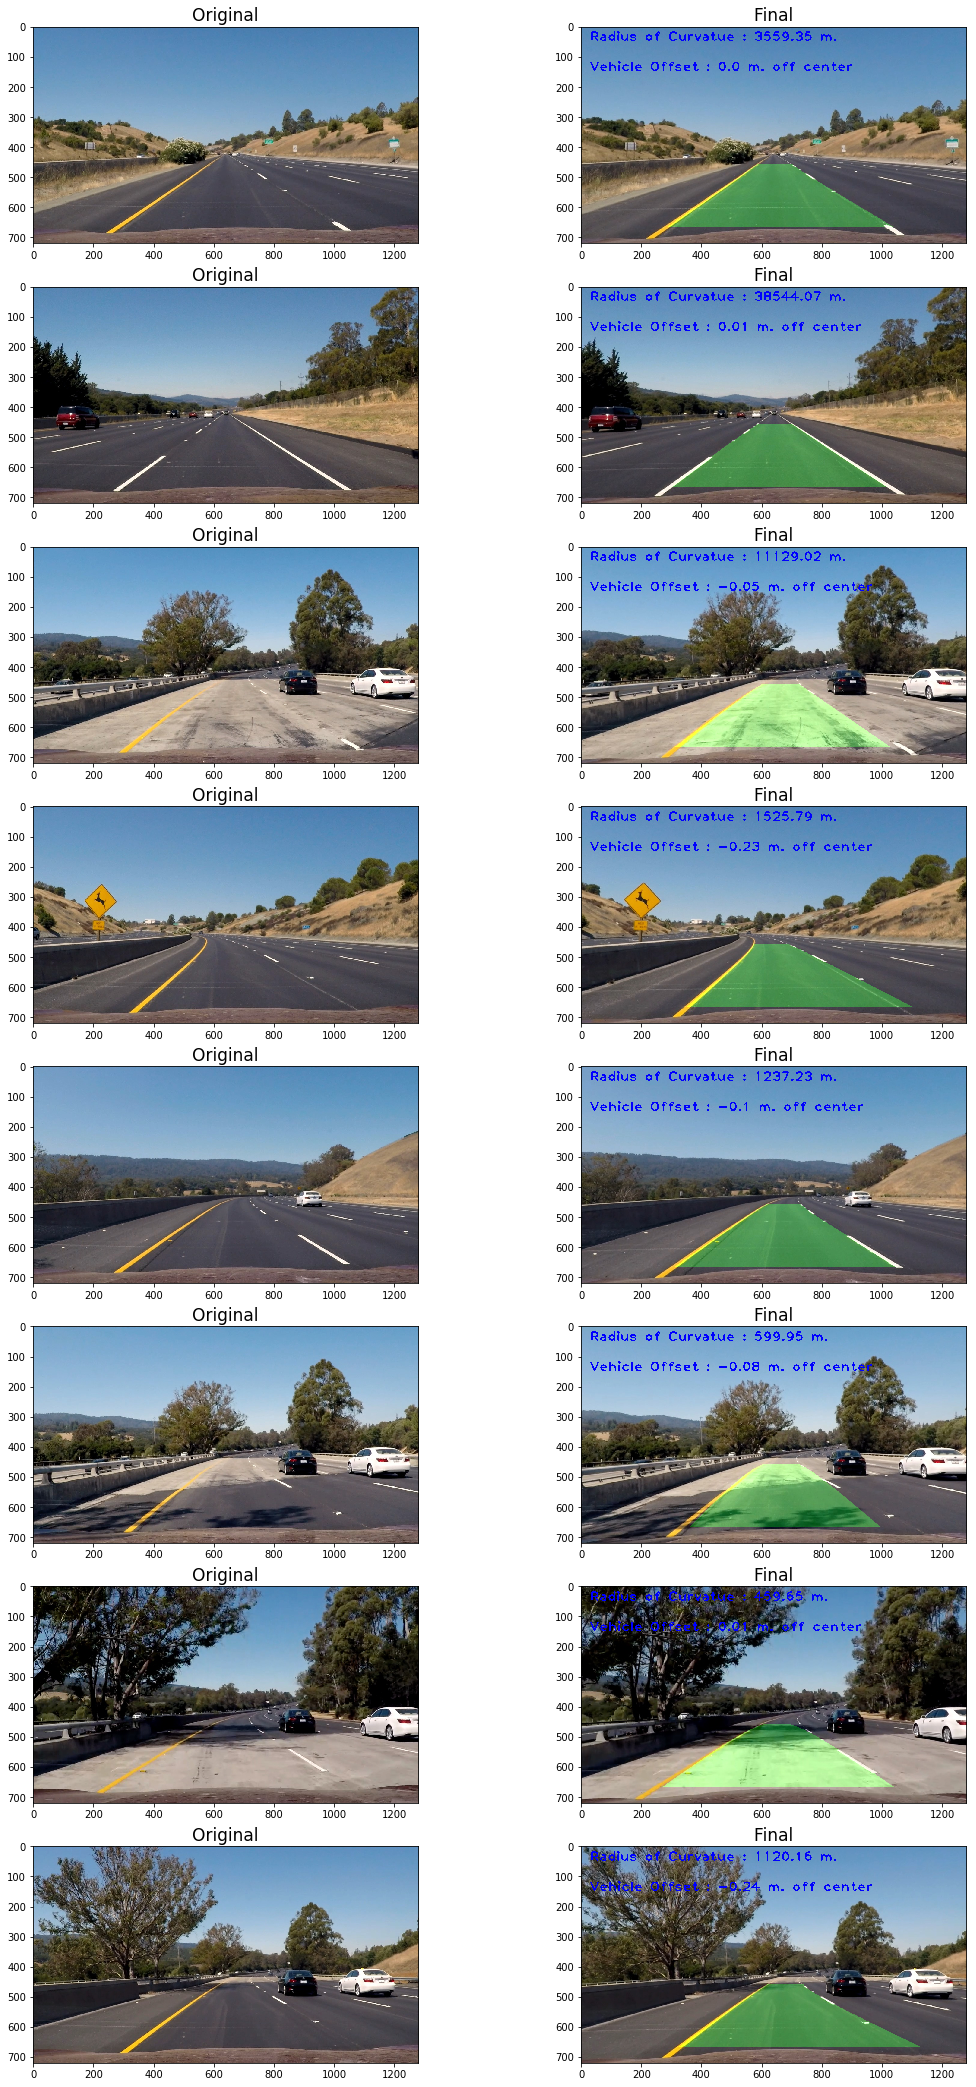

In [158]:
global left_lane, right_lane, first_run


final_images = []
for i in range(len(test_images)):
    left_lane=None
    right_lane=None
    first_run = True
    final_images.append(pipeline(test_images[i]))
    
display_images(merge_lists(test_images, final_images), titles=["Original", "Final"]*len(test_images))

In [ ]:
#a,b,c,d,e,f = pipeline(test_images[7], visualize=True)

#display_images([a,b,c,d,e,f], 
#titles=[ "Undistorted", "Color Threshold", "Gradient Threshold",
#                       "Combined Threshold", "Region of Interest", "Warped"],cmap='gray')

In [ ]:
# Find lane lines on a warped image and visualize it

warped, window_img, lf, rf = reset_lane_lines(f, visualize=True)

display_images(warped,window_img,cmap='gray')

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [ ]:
if not os.path.isdir("test_videos_output"):
    os.mkdir("test_videos_output")

In [85]:
v1_output = "test_videos_output/project_video_output.mp4"
project_video = VideoFileClip("project_video.mp4")
clip = project_video.fl_image(pipeline)
%time clip.write_videofile(v1_output, audio=False)

clip.reader.close()
clip.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:19<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

Wall time: 5min 21s


In [84]:
global left_lane, right_lane, first_run

left_lane=None
right_lane=None
first_run = True

clipn = VideoFileClip("project_video.mp4").subclip(35,45)
clip_out = clipn.fl_image(pipeline)
%time clip_out.write_videofile("test_videos_output/project_video_mini_output.mp4", audio=False)

clipn.reader.close()
clipn.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/project_video_mini_output.mp4
[MoviePy] Writing video test_videos_output/project_video_mini_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [01:06<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_mini_output.mp4 

Wall time: 1min 7s


In [ ]:
poly = left_lane.get_mean_polyfit()
ycords = np.linspace(0,300,300)
xcords = poly[0]*(ycords**2) + poly[1]*ycords + poly[0]

poly2 = right_lane.get_mean_polyfit()
ycords2 = np.linspace(0,300,300)
xcords2 = poly2[0]*(xcords**2) + poly2[1]*xcords + poly2[0]

plt.plot(xcords,ycords)
plt.plot(xcords2,ycords2)

In [ ]:
right_lane.get_mean_polyfit()

In [ ]:
left_lane.get_mean_polyfit()

In [ ]:
v2_output = "test_videos_output/challenge_video_output.mp4"
project_video2 = VideoFileClip("challenge_video.mp4")
clip2 = project_video2.fl_image(pipeline)
%time clip.write_videofile(v2_output, audio=False)

In [ ]:
v3_output = "test_videos_output/harder_challenge_video_output.mp4"
project_video3 = VideoFileClip("harder_challenge_video.mp4")
clip3 = project_video3.fl_image(pipeline)
%time clip3.write_videofile(v3_output, audio=False)